In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pygsheets
from openpyxl import load_workbook

matplotlib.rc('font', family='Microsoft JhengHei')

In [2]:
# 抓金鑰
gc = pygsheets.authorize(service_file='ccclub_api_key.json')
# 連接雲端 sheet
sht_source = gc.open_by_url(
'https://docs.google.com/spreadsheets/d/1t7U4pvptpD_cfTMD4tUwDeCffAopPQF2hJEt386J18A/'
)
sht_target = gc.open_by_url(
'https://docs.google.com/spreadsheets/d/1uOR-4jq4eBnh3v0Ff20ZtPB-tgNfLNmRaZiHnqzfMbw/'
)

In [3]:
sheet_name = 'mountain_information'
sheet_name_weather = 'weather_information'
sheet_name_trail = 'trail_information'
sheet_name_chalet = 'chalet'
cl_sheet_name = 'mountain_information'
cl_sheet_name_weather = 'weather_information'
cl_sheet_name_trail = 'trail_information'
cl_sheet_name_chalet = 'chalet_information'
cl_sheet_name_inter1 = 'mountain_city'
cl_sheet_name_inter2 = 'mountain_trail'
cl_sheet_name_inter3 = 'trail_city'
cl_sheet_name_inter4 = 'trail_mountain'

In [4]:
# 上傳清理好的表
def upload_to_google_sheet(url, new_data, sheet_name):
    try:
        # 嘗試讀取現有的 Excel 檔案
        ws = url.worksheet_by_title(sheet_name)
    except Exception as e:
        # 如果檔案不存在，創建一個空的 DataFrame
        ws = url.add_worksheet(sheet_name)

    # 將合併後的資料寫入 Excel 檔案
    ws.set_dataframe(new_data, (1,1),nan='')

### 山岳資訊清理

In [10]:
# 嘗試讀取現有的 Excel 檔案
ws = sht_source.worksheet_by_title(sheet_name)
existing_df = pd.DataFrame(ws.get_all_records())
existing_df

,山岳ID,山岳名稱,人想去,人去過,次點閱,類別,別名,國家,所在縣市,標高,所屬園區,所屬山系,申請入山,申請入園,相關步道,基點,備註,簡介
0,1,玉山主峰,276,3324,27985,台灣百岳,新高山∕摩里遜山,台灣,"南投縣信義鄉,嘉義縣阿里山鄉,高雄市桃源區","3,952公尺",玉山國家公園,玉山山脈,要,要,"玉山主峰步道,玉山後四峰登山步道,玉山前五峰登山步道,玉山群峰線,八通關上玉山(東埔進塔塔加...",一等三角點,五嶽之一,玉山主峰位於台灣的中心位置，海拔3952公尺，為台灣群山之首，百岳排名第一，也是東北亞的最高...
1,2,雪山主峰,253,2526,37282,台灣百岳,西魯維亞山∕興隆山∕次高山∕哈蓋山∕馬哈馬顏山∕雪翁山,台灣,"苗栗縣泰安鄉,臺中市和平區","3,886公尺",雪霸國家公園,雪山山脈,否,要,"雪山主東峰步道,聖稜線O型縱走(O聖),雪劍線,雪山西稜線,雪山下翠池,聖稜線Y型縱走(Y聖...",一等三角點,五嶽之一,雪山標高3886公尺，屬於雪山山脈，為全台灣第二高峰，僅次於玉山山脈的玉山主峰（3952公尺...
2,3,玉山東峰,131,634,33392,台灣百岳,台東新高∕天壘峰∕東山∕新高東山∕齊藤峰,台灣,"南投縣信義鄉,嘉義縣阿里山鄉","3,869公尺",玉山國家公園,玉山山脈,要,要,"玉山前五峰登山步道,玉山群峰線",無基點,十峻之一,玉山東峰標高3869公尺，日治時期名為東山、新高東山、台東新高，山體岩壁崢嶸，巍峨險要，台灣...
3,4,玉山北峰,152,1002,37002,台灣百岳,斗六新高∕北山∕新高北山∕天駝峰,台灣,南投縣信義鄉,"3,858公尺",玉山國家公園,玉山山脈,要,要,"玉山前五峰登山步道,玉山群峰線",無基點,八秀,玉山北峰是台灣玉山山脈中的一座山峰，為台灣百岳名峰之一，位於玉山主峰北側，標高3858公尺。...
4,5,玉山南峰,87,373,14065,台灣百岳,天龍峰∕玉山天龍峰∕閉鎖曲線峰∕南山∕新高南山∕玉山三叉峰,台灣,高雄市桃源區,"3,844公尺",玉山國家公園,玉山山脈,要,要,"玉山後四峰登山步道,玉山群峰線",無基點,十峻之一,玉山南峰，日治時期名為南山、新高南山。因自主峰遠眺，山稜蜿蜒，酷似遊龍，故又名天龍峰。在某些...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,7806,金頭山,0,5,581,,-,台灣,台北市文山區,300公尺,-,-,否,否,,,,
3072,7807,金頭山東峰,0,4,474,,-,台灣,台北市文山區,304公尺,-,-,否,否,,,,
3073,7808,關刀山,4,19,4397,,-,台灣,"南投縣埔里鎮, 南投縣仁愛鄉,","2,017公尺",-,雪山山脈,否,否,埔里關刀山步道,聯勤三等三角點內補314號,,關刀山位於南投縣埔里鎮和仁愛鄉交界附近，為埔里六秀之一。因山形雄偉壯闊，宛如關刀橫臥而得名，...
3074,7809,南庄石壁山,0,0,1681,,-,台灣,"苗栗縣南庄鄉,",810公尺,-,-,否,否,,山字森林三角點,,石壁山，位於苗栗縣南庄鄉東河村，海拔810公尺，山字森林三角點。由石壁部落走保線路可至，三角...


In [11]:
existing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   山岳ID    3076 non-null   int64 
 1   山岳名稱    3076 non-null   object
 2   人想去     3076 non-null   int64 
 3   人去過     3076 non-null   int64 
 4   次點閱     3076 non-null   int64 
 5   類別      3076 non-null   object
 6   別名      3076 non-null   object
 7   國家      3076 non-null   object
 8   所在縣市    3076 non-null   object
 9   標高      3076 non-null   object
 10  所屬園區    3076 non-null   object
 11  所屬山系    3076 non-null   object
 12  申請入山    3076 non-null   object
 13  申請入園    3076 non-null   object
 14  相關步道    3076 non-null   object
 15  基點      3076 non-null   object
 16  備註      3076 non-null   object
 17  簡介      3076 non-null   object
dtypes: int64(4), object(14)
memory usage: 432.7+ KB


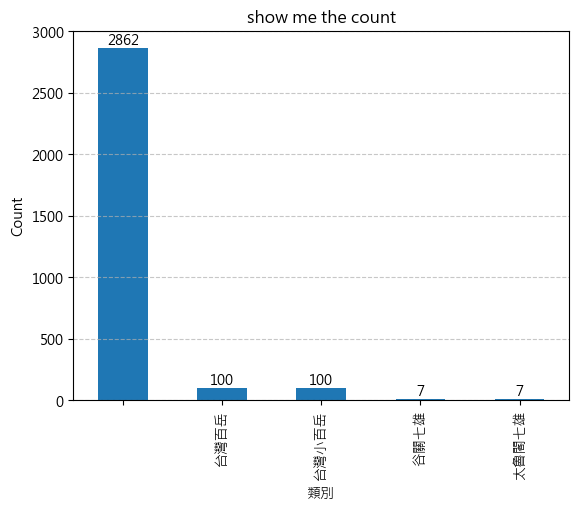

In [29]:
show_cnt = existing_df['類別'].value_counts()
show_cnt.plot(kind='bar')

# 添加標題和軸的標籤
plt.title('show me the count')
plt.xlabel('類別')
plt.ylabel('Count')

# 顯示數值標籤
for i, v in enumerate(show_cnt):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 清理完後的新DataFrame

In [125]:
new_df = existing_df.copy()
# 將空白轉空值
values_to_replace = [' ', '無', '無基點', '-']
new_df['類別'] = new_df['類別'].replace(r'^\s*$', np.nan, regex=True)
new_df['別名'] = new_df['別名'].replace(values_to_replace, np.nan)
new_df['標高'] = new_df['標高'].str.replace(r'[^\w\s]', '', regex=True)
new_df[['標高(公尺)']] = new_df['標高'].str.extract(r'(\d+)').astype(int)
#new_df[['標高(值)', '標高(單位)']] = new_df['標高'].str.extract(r'(\d+)(\D+)')
new_df['所屬園區'] = new_df['所屬園區'].replace(values_to_replace, np.nan)
new_df['所屬山系'] = new_df['所屬山系'].replace(values_to_replace, np.nan)
new_df['相關步道'] = new_df['相關步道'].replace(values_to_replace, np.nan)
new_df['相關步道'] = new_df['相關步道'].replace(r'^\s*$', np.nan, regex=True)
new_df['基點'] = new_df['基點'].replace(values_to_replace, np.nan)
new_df['基點'] = new_df['基點'].replace(r'^\s*$', np.nan, regex=True)
new_df['備註'] = new_df['備註'].replace(values_to_replace, np.nan)
new_df['備註'] = new_df['備註'].replace(r'^\s*$', np.nan, regex=True)
new_df['簡介'] = new_df['簡介'].replace(values_to_replace, np.nan)
new_df['簡介'] = new_df['簡介'].replace(r'^\s*$', np.nan, regex=True)

new_df = new_df.drop(columns=['標高'])
new_df = new_df.reindex(columns=['山岳ID', '山岳名稱', '人想去', '人去過', '次點閱', '類別', '別名', '國家', '所在縣市', '標高(公尺)', '所屬園區', '所屬山系', '申請入山',
                                 '申請入園', '相關步道', '基點', '備註', '簡介'])
new_df

,山岳ID,山岳名稱,人想去,人去過,次點閱,類別,別名,國家,所在縣市,標高(公尺),所屬園區,所屬山系,申請入山,申請入園,相關步道,基點,備註,簡介
0,1,玉山主峰,276,3324,27985,台灣百岳,新高山∕摩里遜山,台灣,"南投縣信義鄉,嘉義縣阿里山鄉,高雄市桃源區",3952,玉山國家公園,玉山山脈,要,要,"玉山主峰步道,玉山後四峰登山步道,玉山前五峰登山步道,玉山群峰線,八通關上玉山(東埔進塔塔加...",一等三角點,五嶽之一,玉山主峰位於台灣的中心位置，海拔3952公尺，為台灣群山之首，百岳排名第一，也是東北亞的最高...
1,2,雪山主峰,253,2526,37282,台灣百岳,西魯維亞山∕興隆山∕次高山∕哈蓋山∕馬哈馬顏山∕雪翁山,台灣,"苗栗縣泰安鄉,臺中市和平區",3886,雪霸國家公園,雪山山脈,否,要,"雪山主東峰步道,聖稜線O型縱走(O聖),雪劍線,雪山西稜線,雪山下翠池,聖稜線Y型縱走(Y聖...",一等三角點,五嶽之一,雪山標高3886公尺，屬於雪山山脈，為全台灣第二高峰，僅次於玉山山脈的玉山主峰（3952公尺...
2,3,玉山東峰,131,634,33392,台灣百岳,台東新高∕天壘峰∕東山∕新高東山∕齊藤峰,台灣,"南投縣信義鄉,嘉義縣阿里山鄉",3869,玉山國家公園,玉山山脈,要,要,"玉山前五峰登山步道,玉山群峰線",NaN,十峻之一,玉山東峰標高3869公尺，日治時期名為東山、新高東山、台東新高，山體岩壁崢嶸，巍峨險要，台灣...
3,4,玉山北峰,152,1002,37002,台灣百岳,斗六新高∕北山∕新高北山∕天駝峰,台灣,南投縣信義鄉,3858,玉山國家公園,玉山山脈,要,要,"玉山前五峰登山步道,玉山群峰線",NaN,八秀,玉山北峰是台灣玉山山脈中的一座山峰，為台灣百岳名峰之一，位於玉山主峰北側，標高3858公尺。...
4,5,玉山南峰,87,373,14065,台灣百岳,天龍峰∕玉山天龍峰∕閉鎖曲線峰∕南山∕新高南山∕玉山三叉峰,台灣,高雄市桃源區,3844,玉山國家公園,玉山山脈,要,要,"玉山後四峰登山步道,玉山群峰線",NaN,十峻之一,玉山南峰，日治時期名為南山、新高南山。因自主峰遠眺，山稜蜿蜒，酷似遊龍，故又名天龍峰。在某些...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,7806,金頭山,0,5,581,NaN,NaN,台灣,台北市文山區,300,NaN,NaN,否,否,NaN,NaN,NaN,NaN
3072,7807,金頭山東峰,0,4,474,NaN,NaN,台灣,台北市文山區,304,NaN,NaN,否,否,NaN,NaN,NaN,NaN
3073,7808,關刀山,4,19,4397,NaN,NaN,台灣,"南投縣埔里鎮, 南投縣仁愛鄉,",2017,NaN,雪山山脈,否,否,埔里關刀山步道,聯勤三等三角點內補314號,NaN,關刀山位於南投縣埔里鎮和仁愛鄉交界附近，為埔里六秀之一。因山形雄偉壯闊，宛如關刀橫臥而得名，...
3074,7809,南庄石壁山,0,0,1681,NaN,NaN,台灣,"苗栗縣南庄鄉,",810,NaN,NaN,否,否,NaN,山字森林三角點,NaN,石壁山，位於苗栗縣南庄鄉東河村，海拔810公尺，山字森林三角點。由石壁部落走保線路可至，三角...


In [215]:
city_df = new_df[['山岳ID', '山岳名稱', '所在縣市']].copy()

# 拆分 '所在縣市' 列中的多个地點
# 使用 .loc 進行赋值，避免 SettingWithCopyWarning
city_df.loc[:, '所在縣市'] = city_df['所在縣市'].str.split(',')

# 使用 explode 方法將一行拆分成多行
city_df = city_df.explode('所在縣市')

# 重置索引
city_df.reset_index(drop=True, inplace=True)

# 清除空白
city_df['所在縣市'] = city_df['所在縣市'].replace(r'^\s*$', np.nan, regex=True)
# 移除所有列中的頭尾空格
city_df = city_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

city_df['縣市'] = city_df['所在縣市'].str[:3]
city_df['鄉鎮市'] = city_df['所在縣市'].str[3:]
city_df['鄉鎮市'] = city_df['鄉鎮市'].replace(r'^\s*$', np.nan, regex=True)

city_df = city_df.drop(columns=['山岳名稱', '所在縣市'])
city_df.head(30)

,山岳ID,縣市,鄉鎮市
0,1,南投縣,信義鄉
1,1,嘉義縣,阿里山鄉
2,1,高雄市,桃源區
3,2,苗栗縣,泰安鄉
4,2,臺中市,和平區
5,3,南投縣,信義鄉
6,3,嘉義縣,阿里山鄉
7,4,南投縣,信義鄉
8,5,高雄市,桃源區
9,6,南投縣,信義鄉


In [222]:
trail_df = new_df[['山岳ID', '山岳名稱', '相關步道']].copy()

# 拆分 '所在縣市' 列中的多个地點
# 使用 .loc 進行赋值，避免 SettingWithCopyWarning
trail_df.loc[:, '相關步道'] = trail_df['相關步道'].str.split(',')

# 使用 explode 方法將一行拆分成多行
trail_df = trail_df.explode('相關步道')

# 重置索引
trail_df.reset_index(drop=True, inplace=True)

# 清除空白
trail_df['相關步道'] = trail_df['相關步道'].replace(r'^\s*$', np.nan, regex=True)
# 移除所有列中的頭尾空格
trail_df = trail_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

trail_df = trail_df.drop(columns=['山岳名稱'])
trail_df.head(30)

,山岳ID,相關步道
0,1,玉山主峰步道
1,1,玉山後四峰登山步道
2,1,玉山前五峰登山步道
3,1,玉山群峰線
4,1,八通關上玉山(東埔進塔塔加出)
5,1,玉山主峰單日往返
6,2,雪山主東峰步道
7,2,聖稜線O型縱走(O聖)
8,2,雪劍線
9,2,雪山西稜線


In [223]:
upload_new_df = new_df.drop(columns=['所在縣市', '相關步道'])
upload_new_df

,山岳ID,山岳名稱,人想去,人去過,次點閱,類別,別名,國家,標高(公尺),所屬園區,所屬山系,申請入山,申請入園,基點,備註,簡介
0,1,玉山主峰,276,3324,27985,台灣百岳,新高山∕摩里遜山,台灣,3952,玉山國家公園,玉山山脈,要,要,一等三角點,五嶽之一,玉山主峰位於台灣的中心位置，海拔3952公尺，為台灣群山之首，百岳排名第一，也是東北亞的最高...
1,2,雪山主峰,253,2526,37282,台灣百岳,西魯維亞山∕興隆山∕次高山∕哈蓋山∕馬哈馬顏山∕雪翁山,台灣,3886,雪霸國家公園,雪山山脈,否,要,一等三角點,五嶽之一,雪山標高3886公尺，屬於雪山山脈，為全台灣第二高峰，僅次於玉山山脈的玉山主峰（3952公尺...
2,3,玉山東峰,131,634,33392,台灣百岳,台東新高∕天壘峰∕東山∕新高東山∕齊藤峰,台灣,3869,玉山國家公園,玉山山脈,要,要,NaN,十峻之一,玉山東峰標高3869公尺，日治時期名為東山、新高東山、台東新高，山體岩壁崢嶸，巍峨險要，台灣...
3,4,玉山北峰,152,1002,37002,台灣百岳,斗六新高∕北山∕新高北山∕天駝峰,台灣,3858,玉山國家公園,玉山山脈,要,要,NaN,八秀,玉山北峰是台灣玉山山脈中的一座山峰，為台灣百岳名峰之一，位於玉山主峰北側，標高3858公尺。...
4,5,玉山南峰,87,373,14065,台灣百岳,天龍峰∕玉山天龍峰∕閉鎖曲線峰∕南山∕新高南山∕玉山三叉峰,台灣,3844,玉山國家公園,玉山山脈,要,要,NaN,十峻之一,玉山南峰，日治時期名為南山、新高南山。因自主峰遠眺，山稜蜿蜒，酷似遊龍，故又名天龍峰。在某些...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,7806,金頭山,0,5,581,NaN,NaN,台灣,300,NaN,NaN,否,否,NaN,NaN,NaN
3072,7807,金頭山東峰,0,4,474,NaN,NaN,台灣,304,NaN,NaN,否,否,NaN,NaN,NaN
3073,7808,關刀山,4,19,4397,NaN,NaN,台灣,2017,NaN,雪山山脈,否,否,聯勤三等三角點內補314號,NaN,關刀山位於南投縣埔里鎮和仁愛鄉交界附近，為埔里六秀之一。因山形雄偉壯闊，宛如關刀橫臥而得名，...
3074,7809,南庄石壁山,0,0,1681,NaN,NaN,台灣,810,NaN,NaN,否,否,山字森林三角點,NaN,石壁山，位於苗栗縣南庄鄉東河村，海拔810公尺，山字森林三角點。由石壁部落走保線路可至，三角...


In [227]:
upload_to_google_sheet(sht_target, upload_new_df, cl_sheet_name)
upload_to_google_sheet(sht_target, city_df, cl_sheet_name_inter1)
upload_to_google_sheet(sht_target, trail_df, cl_sheet_name_inter2)

### 天氣資訊清理

In [7]:
# 嘗試讀取現有的 Excel 檔案
ws_weather = sht_source.worksheet_by_title(sheet_name_weather)
existing_wea_df = pd.DataFrame(ws_weather.get_all_records())
existing_wea_df

,County(縣市),Longitude(經度),Latitude(緯度),Start_Time(開始時間),End_time(結束時間),PoP12h(12小時降雨機率),T(平均溫度),RH(平均相對濕度),MinCI(最小舒適度指數),WS(最大風速),MaxAT(最高體感溫度),Wx(天氣現象),MaxCI(最大舒適度指數),MinT(最低溫度),UVI(紫外線指數),WeatherDescription(天氣預報綜合描述),MinAT(最低體感溫度),MaxT(最高溫度),WD(風向),Td(平均露點溫度)
0,新竹縣,120.995698,24.841245,2024-06-29 06:00:00,2024-06-29 18:00:00,30百分比,32攝氏度,71百分比,26,6公尺/秒,37攝氏度,晴午後短暫雷陣雨,31,27攝氏度,10紫外線指數,晴午後短暫雷陣雨。降雨機率 30%。溫度攝氏27至34度。舒適至易中暑。西南風 風速4級(每...,29攝氏度,34攝氏度,西南風8方位,26攝氏度
1,新竹縣,120.995698,24.841245,2024-06-29 18:00:00,2024-06-30 06:00:00,20百分比,29攝氏度,83百分比,27,6公尺/秒,35攝氏度,晴時多雲,30,28攝氏度,10紫外線指數,晴時多雲。降雨機率 20%。溫度攝氏28至32度。悶熱。偏南風 風速4級(每秒6公尺)。相對...,29攝氏度,32攝氏度,偏南風8方位,26攝氏度
2,新竹縣,120.995698,24.841245,2024-06-30 06:00:00,2024-06-30 18:00:00,20百分比,32攝氏度,74百分比,27,8公尺/秒,37攝氏度,晴時多雲,31,28攝氏度,9紫外線指數,晴時多雲。降雨機率 20%。溫度攝氏28至34度。悶熱至易中暑。西南風 風速4級(每秒8公尺...,29攝氏度,34攝氏度,西南風8方位,27攝氏度
3,新竹縣,120.995698,24.841245,2024-06-30 18:00:00,2024-07-01 06:00:00,20百分比,29攝氏度,82百分比,26,6公尺/秒,33攝氏度,晴時多雲,29,28攝氏度,9紫外線指數,晴時多雲。降雨機率 20%。溫度攝氏28至31度。舒適至悶熱。西南風 風速4級(每秒6公尺)...,31攝氏度,31攝氏度,西南風8方位,26攝氏度
4,新竹縣,120.995698,24.841245,2024-07-01 06:00:00,2024-07-01 18:00:00,20百分比,32攝氏度,75百分比,26,5公尺/秒,39攝氏度,多雲時晴,31,28攝氏度,9紫外線指數,多雲時晴。降雨機率 20%。溫度攝氏28至34度。舒適至易中暑。西南風 風速3級(每秒5公尺...,31攝氏度,34攝氏度,西南風8方位,27攝氏度
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,新竹市,120.962110,24.818109,2024-06-30 18:00:00,2024-07-01 06:00:00,null,29攝氏度,83百分比,26,3公尺/秒,36攝氏度,多雲時晴,29,28攝氏度,null,多雲時晴。溫度攝氏28至31度。舒適至悶熱。偏南風 風速2級(每秒3公尺)。相對濕度83%。,32攝氏度,31攝氏度,偏南風8方位,26攝氏度
326,新竹市,120.962110,24.818109,2024-07-01 06:00:00,2024-07-01 18:00:00,null,31攝氏度,77百分比,26,6公尺/秒,38攝氏度,多雲午後短暫雷陣雨,30,28攝氏度,null,多雲午後短暫雷陣雨。溫度攝氏28至33度。舒適至悶熱。偏南風 風速4級(每秒6公尺)。相對濕...,32攝氏度,33攝氏度,偏南風8方位,27攝氏度
327,新竹市,120.962110,24.818109,2024-07-01 18:00:00,2024-07-02 06:00:00,null,29攝氏度,86百分比,26,2公尺/秒,36攝氏度,多雲短暫陣雨,30,28攝氏度,null,多雲短暫陣雨。溫度攝氏28至31度。舒適至悶熱。偏南風 風速<= 1級(每秒2公尺)。相對濕...,33攝氏度,31攝氏度,偏南風8方位,27攝氏度
328,新竹市,120.962110,24.818109,2024-07-02 06:00:00,2024-07-02 18:00:00,null,31攝氏度,76百分比,26,3公尺/秒,39攝氏度,晴午後短暫雷陣雨,30,28攝氏度,null,晴午後短暫雷陣雨。溫度攝氏28至32度。舒適至悶熱。偏南風 風速2級(每秒3公尺)。相對濕度...,33攝氏度,32攝氏度,偏南風8方位,26攝氏度


In [8]:
existing_wea_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   County(縣市)                    330 non-null    object 
 1   Longitude(經度)                 330 non-null    float64
 2   Latitude(緯度)                  330 non-null    float64
 3   Start_Time(開始時間)              330 non-null    object 
 4   End_time(結束時間)                330 non-null    object 
 5   PoP12h(12小時降雨機率)              330 non-null    object 
 6   T(平均溫度)                       330 non-null    object 
 7   RH(平均相對濕度)                    330 non-null    object 
 8   MinCI(最小舒適度指數)                330 non-null    int64  
 9   WS(最大風速)                      330 non-null    object 
 10  MaxAT(最高體感溫度)                 330 non-null    object 
 11  Wx(天氣現象)                      330 non-null    object 
 12  MaxCI(最大舒適度指數)                330 non-null    int64  
 13  MinT(

### 清理完後的新DataFrame

In [18]:
def time_of_day(time):
    if time.time() == pd.Timestamp('06:00:00').time():
        return '白天'
    elif time.time() == pd.Timestamp('18:00:00').time():
        return '晚間'
    else:
        return '其他'

In [78]:
new_wea_df = existing_wea_df.copy()
# 轉換成日期資料型態
new_wea_df['Start_Time(開始時間)'] = pd.to_datetime(new_wea_df['Start_Time(開始時間)'], errors='coerce')
new_wea_df['End_time(結束時間)'] = pd.to_datetime(new_wea_df['End_time(結束時間)'], errors='coerce')
new_wea_df['Time_period(時段)'] = new_wea_df['Start_Time(開始時間)'].apply(time_of_day)
# 拆分轉換數字
# 使用正則表達式提取数字，如果没有匹配則返回 NaN
new_wea_df['PoP12h(12小時降雨機率_%)'] = new_wea_df['PoP12h(12小時降雨機率)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['T(平均溫度_C)'] = new_wea_df['T(平均溫度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['RH(平均相對濕度_%)'] = new_wea_df['RH(平均相對濕度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['WS(最大風速_m/s)'] = new_wea_df['WS(最大風速)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['MaxAT(最高體感溫度_C)'] = new_wea_df['MaxAT(最高體感溫度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['MinAT(最低體感溫度_C)'] = new_wea_df['MinAT(最低體感溫度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['MaxT(最高溫度_C)'] = new_wea_df['MaxT(最高溫度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['MinT(最低溫度_C)'] = new_wea_df['MinT(最低溫度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['UVI(紫外線指數)'] = new_wea_df['UVI(紫外線指數)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')
new_wea_df['Td(平均露點溫度_C)'] = new_wea_df['Td(平均露點溫度)']\
    .str.extract(r'(\d+)')[0].replace('null', np.nan).astype('float').astype('Int64')

new_wea_df = new_wea_df.drop(columns=['PoP12h(12小時降雨機率)', 'T(平均溫度)', 'RH(平均相對濕度)', 'WS(最大風速)',
                                      'MaxAT(最高體感溫度)', 'MinAT(最低體感溫度)', 'MaxT(最高溫度)', 'MinT(最低溫度)', 'Td(平均露點溫度)'])
new_wea_df = new_wea_df.reindex(columns=['County(縣市)', 'Longitude(經度)', 'Latitude(緯度)', 'Start_Time(開始時間)', 'End_time(結束時間)',
                                         'Time_period(時段)', 'MinCI(最小舒適度指數)', 'MaxCI(最大舒適度指數)', 'PoP12h(12小時降雨機率_%)', 'T(平均溫度_C)',
                                         'RH(平均相對濕度_%)', 'WS(最大風速_m/s)', 'WD(風向)', 'MaxAT(最高體感溫度_C)', 'MinAT(最低體感溫度_C)',
                                         'MaxT(最高溫度_C)', 'MinT(最低溫度_C)', 'UVI(紫外線指數)', 'Td(平均露點溫度_C)', 'Wx(天氣現象)', 'WeatherDescription(天氣預報綜合描述)'])
new_wea_df

,County(縣市),Longitude(經度),Latitude(緯度),Start_Time(開始時間),End_time(結束時間),Time_period(時段),MinCI(最小舒適度指數),MaxCI(最大舒適度指數),PoP12h(12小時降雨機率_%),T(平均溫度_C),...,WS(最大風速_m/s),WD(風向),MaxAT(最高體感溫度_C),MinAT(最低體感溫度_C),MaxT(最高溫度_C),MinT(最低溫度_C),UVI(紫外線指數),Td(平均露點溫度_C),Wx(天氣現象),WeatherDescription(天氣預報綜合描述)
0,新竹縣,120.995698,24.841245,2024-06-29 06:00:00,2024-06-29 18:00:00,白天,26,31,30,32,...,6,西南風8方位,37,29,34,27,10,26,晴午後短暫雷陣雨,晴午後短暫雷陣雨。降雨機率 30%。溫度攝氏27至34度。舒適至易中暑。西南風 風速4級(每...
1,新竹縣,120.995698,24.841245,2024-06-29 18:00:00,2024-06-30 06:00:00,晚間,27,30,20,29,...,6,偏南風8方位,35,29,32,28,10,26,晴時多雲,晴時多雲。降雨機率 20%。溫度攝氏28至32度。悶熱。偏南風 風速4級(每秒6公尺)。相對...
2,新竹縣,120.995698,24.841245,2024-06-30 06:00:00,2024-06-30 18:00:00,白天,27,31,20,32,...,8,西南風8方位,37,29,34,28,9,27,晴時多雲,晴時多雲。降雨機率 20%。溫度攝氏28至34度。悶熱至易中暑。西南風 風速4級(每秒8公尺...
3,新竹縣,120.995698,24.841245,2024-06-30 18:00:00,2024-07-01 06:00:00,晚間,26,29,20,29,...,6,西南風8方位,33,31,31,28,9,26,晴時多雲,晴時多雲。降雨機率 20%。溫度攝氏28至31度。舒適至悶熱。西南風 風速4級(每秒6公尺)...
4,新竹縣,120.995698,24.841245,2024-07-01 06:00:00,2024-07-01 18:00:00,白天,26,31,20,32,...,5,西南風8方位,39,31,34,28,9,27,多雲時晴,多雲時晴。降雨機率 20%。溫度攝氏28至34度。舒適至易中暑。西南風 風速3級(每秒5公尺...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,新竹市,120.962110,24.818109,2024-06-30 18:00:00,2024-07-01 06:00:00,晚間,26,29,<NA>,29,...,3,偏南風8方位,36,32,31,28,<NA>,26,多雲時晴,多雲時晴。溫度攝氏28至31度。舒適至悶熱。偏南風 風速2級(每秒3公尺)。相對濕度83%。
326,新竹市,120.962110,24.818109,2024-07-01 06:00:00,2024-07-01 18:00:00,白天,26,30,<NA>,31,...,6,偏南風8方位,38,32,33,28,<NA>,27,多雲午後短暫雷陣雨,多雲午後短暫雷陣雨。溫度攝氏28至33度。舒適至悶熱。偏南風 風速4級(每秒6公尺)。相對濕...
327,新竹市,120.962110,24.818109,2024-07-01 18:00:00,2024-07-02 06:00:00,晚間,26,30,<NA>,29,...,2,偏南風8方位,36,33,31,28,<NA>,27,多雲短暫陣雨,多雲短暫陣雨。溫度攝氏28至31度。舒適至悶熱。偏南風 風速<= 1級(每秒2公尺)。相對濕...
328,新竹市,120.962110,24.818109,2024-07-02 06:00:00,2024-07-02 18:00:00,白天,26,30,<NA>,31,...,3,偏南風8方位,39,33,32,28,<NA>,26,晴午後短暫雷陣雨,晴午後短暫雷陣雨。溫度攝氏28至32度。舒適至悶熱。偏南風 風速2級(每秒3公尺)。相對濕度...


In [81]:
# 上傳
upload_to_google_sheet(sht_target, new_wea_df, cl_sheet_name_weather)

### 步道資訊清理

In [5]:
# 嘗試讀取現有的 Excel 檔案
ws_trail = sht_source.worksheet_by_title(sheet_name_trail)
existing_trail_df = pd.DataFrame(ws_trail.get_all_records())
existing_trail_df

,步道ID,步道名稱,所在縣市,里程,步道類型,步道型態,海拔高度,高度落差,路面狀況,所需時間,...,申請入山,申請入園,附近步道,相關山岳名稱,相關山岳ID,基點,交通-開車,交通-大眾運輸,百岳/小百岳,相關植物
0,5,咬人狗坑登山步道(三汀山),臺中市太平區,單程3.9公里,郊山步道,必須折返,120~481公尺,361公尺,水泥、石板、木階、泥土,3 小時 (往返),...,否,否,,三汀山、埤頭山,"1,415,587",三汀山/481m/三等三角點/陸補145號基石,一江橋堤防道路:\n1.經由快速公路南下：台中生活圈4號道路（台74號快速道路）26K往太平...,一江橋堤防道路:\n搭乘41、75、85、242、246、280、286、287、288，至...,三汀山,
1,6,鯉魚山親山步道,臺北市內湖區,1.6公里,郊山步道,雙向進出,42~222公尺,180公尺,石板、石階,50 分鐘,...,否,否,碧湖親山步道(新福本坑)、忠勇山親山步道、大溝溪溪畔步道、圓覺寺步道,鯉魚山,482,鯉魚山/222m/土地調查局圖根點/編號：無,大湖街131巷登山口:\n國道一號東湖交流道(東湖/南港)出口→康寧路三段→成功路五段、四段...,大湖街131巷登山口:\n1.搭乘捷運文湖線在大湖公園站下車，步行1300公尺，20分鐘可到...,,
2,9,錐麓古道,花蓮縣秀林鄉,10.3公里,郊山步道,雙向進出,280~810公尺,530公尺,原始路面,7 小時,...,否,是，前往申請,綠水步道、砂卡礑步道、白楊步道、燕子口步道、九曲洞步道、花蓮海鼠山警備道,,,無,慈母橋:\n車輛請先停至合流停車場(距慈母橋入口約1公里)，再步行至慈母橋入口。\n\n\n...,慈母橋:\n太魯閣客運(302綠能公車)於慈母橋西端公路旁設有招呼站。\n\n花蓮客運113...,,
3,10,頂山—石梯嶺步道,臺北市士林區,6.4公里,郊山步道,雙向進出,597~865公尺,268公尺,石階、石板路、泥土路、草坡,3 小時,...,否,否,七星山主峰、東峰步道、擎天崗環形步道、陽明山東西大縱走、冷擎步道、陽明山東段縱走、風擎步道(...,頂山、石梯嶺山、杏林山,"2,152,367,416",1.頂山/768m/三等三角點/編號：1033 瑪鋉溪水源保護區界水泥基石/編號：082....,風櫃嘴登山口:\n1.由台北士林外雙溪至善路三段至楓林橋，右轉萬溪產業道路至風櫃嘴。\n2....,風櫃嘴登山口:\n1.搭乘捷運淡水信義線在劍潭站下車，轉乘公車「市巴小巴1」至「風櫃嘴」站下...,,佛氏通泉草、南國小薊
4,12,南仁山生態步道,屏東縣滿州鄉,單程4.3公里,郊山步道,必須折返,140~320公尺,180公尺,原始路徑,3 小時 (往返),...,否,是，前往申請,萬里得山步道,萬里得山,179,無,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,2032,西螺大橋自行車道,雲林縣西螺鎮,1.89公里,郊山步道,環狀,28~31公尺,3公尺,柏油路、紅磚道,1 小時,...,否,否,,,,無,西螺大橋:\n西螺交流站下高速公路，走一號省道至西螺大同路，直走改為大橋路到底。,西螺大橋:\n國光客運西螺站下站後，往警察局方向直走到底右轉至大橋路約10分鐘。,,
1840,2033,恆春鎮古城門,屏東縣恆春鎮,1.74公里,郊山步道,環狀,23~27公尺,4公尺,柏油路、紅磚道,1 小時,...,否,否,,,,無,恆春古城門-南門:\n國道3號424K處下南州交流道→勝利路左轉→第一個路口右轉，走大同路（...,恆春古城門-南門:\n搭高鐵至左營站下-轉搭台灣好行9189墾丁快線至搭高鐵至「恆春轉運」站下。,,
1841,2034,壯圍沙丘生態園區,宜蘭縣壯圍鄉,2.8公里,郊山步道,環狀,1~10公尺,9公尺,柏油路、沙灘,1 小時 30 分鐘,...,否,否,,,,無,壯圍沙丘生態園區:\n國道5號→宜蘭交流道下→縣道191線→鄉道宜12線→省道臺2線→壯圍沙...,壯圍沙丘生態園區:\n1.國光客運壯圍沙丘線綠18(頭城火車站-宜蘭轉運站)→「壯圍沙丘生態...,,
1842,2035,泰山府景觀步道,連江縣東引鄉,0.8公里,郊山步道,雙向進出,43~81公尺,38公尺,石階,20 分鐘,...,否,否,,,,無,泰山府景觀步道(南):\n\n泰山府景觀步道(北):\n開車導航地址：泰山府景觀步道,泰山府景觀步道(南):\n\n泰山府景觀步道(北):\n造訪東引的唯一方式便是海運，可從本島...,,


In [15]:
# columns = existing_trail_df.columns
# columns
existing_trail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   步道ID     1844 non-null   int64 
 1   步道名稱     1844 non-null   object
 2   所在縣市     1844 non-null   object
 3   里程       1844 non-null   object
 4   步道類型     1844 non-null   object
 5   步道型態     1844 non-null   object
 6   海拔高度     1844 non-null   object
 7   高度落差     1844 non-null   object
 8   路面狀況     1844 non-null   object
 9   所需時間     1844 non-null   object
 10  難易度      1844 non-null   object
 11  所屬園區     1844 non-null   object
 12  山脈       1844 non-null   object
 13  最適季節     1844 non-null   object
 14  申請入山     1844 non-null   object
 15  申請入園     1844 non-null   object
 16  附近步道     1844 non-null   object
 17  相關山岳名稱   1844 non-null   object
 18  相關山岳ID   1844 non-null   object
 19  基點       1844 non-null   object
 20  交通-開車    1844 non-null   object
 21  交通-大眾運輸  1844 non-null   object
 22  

### 清理完後的新DataFrame

In [62]:
new_trail_df = existing_trail_df.copy()
# 將空白轉空值
values_to_replace = [' ', '無', '無基點', '-']
# 定義一個函數來提取數字
def extract_number(text):
    match = re.search(r"\d+\.?\d*", text)
    if match:
        number = match.group()
        if '.' in number:
            return round(float(number), 1)
        else:
            return int(number)
    return np.nan

def replace_meter(text):
    # 移除指定字符（如 "公尺"）
    text = text.replace("公尺", "")
    return text
def convert_to_minutes(text):
    total_minutes = 0
    # 匹配所有時間單位（分鐘或小時）
    matches = re.findall(r"(\d+)\s*(分鐘|小時)", text)
    for match in matches:
        number = int(match[0])
        unit = match[1]
        if unit == "小時":
            total_minutes += number * 60
        elif unit == "分鐘":
            total_minutes += number
    return total_minutes if total_minutes > 0 else np.nan
# 應用該函數到 '里程' 列
new_trail_df['里程(公里)'] = new_trail_df['里程'].apply(extract_number)
new_trail_df['高度落差(公尺)'] = new_trail_df['高度落差'].apply(extract_number)
new_trail_df['海拔高度(公尺)'] = new_trail_df['海拔高度'].apply(replace_meter)
new_trail_df['申請入園'] = new_trail_df['申請入園'][0]
new_trail_df['申請入山'] = new_trail_df['申請入山'][0]
new_trail_df['所需時間(分鐘)'] = new_trail_df['所需時間'].apply(convert_to_minutes)

# new_trail_df['標高'] = new_trail_df['標高'].str.replace(r'[^\w\s]', '', regex=True)
# new_trail_df[['標高(公尺)']] = new_trail_df['標高'].str.extract(r'(\d+)').astype(int)
# #new_trail_df[['標高(值)', '標高(單位)']] = new_trail_df['標高'].str.extract(r'(\d+)(\D+)')
# new_trail_df['所屬園區'] = new_trail_df['所屬園區'].replace(values_to_replace, np.nan)
# new_trail_df['所屬山系'] = new_trail_df['所屬山系'].replace(values_to_replace, np.nan)
# new_trail_df['相關步道'] = new_trail_df['相關步道'].replace(values_to_replace, np.nan)
# new_trail_df['相關步道'] = new_trail_df['相關步道'].replace(r'^\s*$', np.nan, regex=True)
# new_trail_df['基點'] = new_trail_df['基點'].replace(values_to_replace, np.nan)
# new_trail_df['基點'] = new_trail_df['基點'].replace(r'^\s*$', np.nan, regex=True)
# new_trail_df['備註'] = new_trail_df['備註'].replace(values_to_replace, np.nan)
# new_trail_df['備註'] = new_trail_df['備註'].replace(r'^\s*$', np.nan, regex=True)
# new_trail_df['簡介'] = new_trail_df['簡介'].replace(values_to_replace, np.nan)
# new_trail_df['簡介'] = new_trail_df['簡介'].replace(r'^\s*$', np.nan, regex=True)
new_trail_df = new_trail_df.reindex(columns=['步道ID', '步道名稱', '相關山岳名稱','所在縣市','里程(公里)', '步道類型', '步道型態', '海拔高度(公尺)', '高度落差(公尺)', '路面狀況', '所需時間(分鐘)', '難易度', '所屬園區', '山脈','最適季節','申請入山','申請入園','附近步道','相關山岳ID','基點','交通-開車','交通-大眾運輸','百岳/小百岳','相關植物'])
new_trail_df

,步道ID,步道名稱,相關山岳名稱,所在縣市,里程(公里),步道類型,步道型態,海拔高度(公尺),高度落差(公尺),路面狀況,...,最適季節,申請入山,申請入園,附近步道,相關山岳ID,基點,交通-開車,交通-大眾運輸,百岳/小百岳,相關植物
0,5,咬人狗坑登山步道(三汀山),三汀山、埤頭山,臺中市太平區,3.9,郊山步道,必須折返,120~481,361.0,水泥、石板、木階、泥土,...,全年,否,否,,"1,415,587",三汀山/481m/三等三角點/陸補145號基石,一江橋堤防道路:\n1.經由快速公路南下：台中生活圈4號道路（台74號快速道路）26K往太平...,一江橋堤防道路:\n搭乘41、75、85、242、246、280、286、287、288，至...,三汀山,
1,6,鯉魚山親山步道,鯉魚山,臺北市內湖區,1.6,郊山步道,雙向進出,42~222,180.0,石板、石階,...,全年,否,否,碧湖親山步道(新福本坑)、忠勇山親山步道、大溝溪溪畔步道、圓覺寺步道,482,鯉魚山/222m/土地調查局圖根點/編號：無,大湖街131巷登山口:\n國道一號東湖交流道(東湖/南港)出口→康寧路三段→成功路五段、四段...,大湖街131巷登山口:\n1.搭乘捷運文湖線在大湖公園站下車，步行1300公尺，20分鐘可到...,,
2,9,錐麓古道,,花蓮縣秀林鄉,10.3,郊山步道,雙向進出,280~810,530.0,原始路面,...,全年,否,否,綠水步道、砂卡礑步道、白楊步道、燕子口步道、九曲洞步道、花蓮海鼠山警備道,,無,慈母橋:\n車輛請先停至合流停車場(距慈母橋入口約1公里)，再步行至慈母橋入口。\n\n\n...,慈母橋:\n太魯閣客運(302綠能公車)於慈母橋西端公路旁設有招呼站。\n\n花蓮客運113...,,
3,10,頂山—石梯嶺步道,頂山、石梯嶺山、杏林山,臺北市士林區,6.4,郊山步道,雙向進出,597~865,268.0,石階、石板路、泥土路、草坡,...,全年,否,否,七星山主峰、東峰步道、擎天崗環形步道、陽明山東西大縱走、冷擎步道、陽明山東段縱走、風擎步道(...,"2,152,367,416",1.頂山/768m/三等三角點/編號：1033 瑪鋉溪水源保護區界水泥基石/編號：082....,風櫃嘴登山口:\n1.由台北士林外雙溪至善路三段至楓林橋，右轉萬溪產業道路至風櫃嘴。\n2....,風櫃嘴登山口:\n1.搭乘捷運淡水信義線在劍潭站下車，轉乘公車「市巴小巴1」至「風櫃嘴」站下...,,佛氏通泉草、南國小薊
4,12,南仁山生態步道,萬里得山,屏東縣滿州鄉,4.3,郊山步道,必須折返,140~320,180.0,原始路徑,...,全年,否,否,萬里得山步道,179,無,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,2032,西螺大橋自行車道,,雲林縣西螺鎮,1.9,郊山步道,環狀,28~31,3.0,柏油路、紅磚道,...,全年,否,否,,,無,西螺大橋:\n西螺交流站下高速公路，走一號省道至西螺大同路，直走改為大橋路到底。,西螺大橋:\n國光客運西螺站下站後，往警察局方向直走到底右轉至大橋路約10分鐘。,,
1840,2033,恆春鎮古城門,,屏東縣恆春鎮,1.7,郊山步道,環狀,23~27,4.0,柏油路、紅磚道,...,全年,否,否,,,無,恆春古城門-南門:\n國道3號424K處下南州交流道→勝利路左轉→第一個路口右轉，走大同路（...,恆春古城門-南門:\n搭高鐵至左營站下-轉搭台灣好行9189墾丁快線至搭高鐵至「恆春轉運」站下。,,
1841,2034,壯圍沙丘生態園區,,宜蘭縣壯圍鄉,2.8,郊山步道,環狀,1~10,9.0,柏油路、沙灘,...,全年,否,否,,,無,壯圍沙丘生態園區:\n國道5號→宜蘭交流道下→縣道191線→鄉道宜12線→省道臺2線→壯圍沙...,壯圍沙丘生態園區:\n1.國光客運壯圍沙丘線綠18(頭城火車站-宜蘭轉運站)→「壯圍沙丘生態...,,
1842,2035,泰山府景觀步道,,連江縣東引鄉,0.8,郊山步道,雙向進出,43~81,38.0,石階,...,全年,否,否,,,無,泰山府景觀步道(南):\n\n泰山府景觀步道(北):\n開車導航地址：泰山府景觀步道,泰山府景觀步道(南):\n\n泰山府景觀步道(北):\n造訪東引的唯一方式便是海運，可從本島...,,


In [63]:
city_df = new_trail_df[['步道ID', '步道名稱', '所在縣市']].copy()

# 拆分 '所在縣市' 列中的多个地點
# 使用 .loc 進行赋值，避免 SettingWithCopyWarning
city_df.loc[:, '所在縣市'] = city_df['所在縣市'].str.split(',')

# 使用 explode 方法將一行拆分成多行
city_df = city_df.explode('所在縣市')

# 重置索引
city_df.reset_index(drop=True, inplace=True)

# 清除空白
city_df['所在縣市'] = city_df['所在縣市'].replace(r'^\s*$', np.nan, regex=True)
# 移除所有列中的頭尾空格
city_df = city_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

city_df['縣市'] = city_df['所在縣市'].str[:3]
city_df['鄉鎮市'] = city_df['所在縣市'].str[3:]
city_df['鄉鎮市'] = city_df['鄉鎮市'].replace(r'^\s*$', np.nan, regex=True)

city_df = city_df.drop(columns=['步道名稱', '所在縣市'])
city_df.head(30)

C:\Users\user\AppData\Local\Temp\ipykernel_58180\2480507891.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  city_df = city_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,步道ID,縣市,鄉鎮市
0,5,臺中市,太平區
1,6,臺北市,內湖區
2,9,花蓮縣,秀林鄉
3,10,臺北市,士林區
4,12,屏東縣,滿州鄉
5,30,基隆市,NaN
6,31,台北市,士林區
7,32,台北市,士林區
8,33,台北市,士林區
9,34,臺北市,士林區


In [64]:
mountain_df = new_trail_df[['步道ID', '步道名稱', '相關山岳名稱']].copy()

# 拆分 '所在縣市' 列中的多个地點
# 使用 .loc 進行赋值，避免 SettingWithCopyWarning
mountain_df.loc[:, '相關山岳名稱'] = mountain_df['相關山岳名稱'].str.split('、')

# 使用 explode 方法將一行拆分成多行
mountain_df = mountain_df.explode('相關山岳名稱')

# 重置索引
mountain_df.reset_index(drop=True, inplace=True)

# 清除空白
mountain_df['相關山岳名稱'] = mountain_df['相關山岳名稱'].replace(r'^\s*$', np.nan, regex=True)
# 移除所有列中的頭尾空格
mountain_df = mountain_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

mountain_df = mountain_df.drop(columns=['步道名稱'])
mountain_df.head(30)

C:\Users\user\AppData\Local\Temp\ipykernel_58180\1465836893.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mountain_df = mountain_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,步道ID,相關山岳名稱
0,5,三汀山
1,5,埤頭山
2,6,鯉魚山
3,9,NaN
4,10,頂山
5,10,石梯嶺山
6,10,杏林山
7,12,萬里得山
8,30,NaN
9,31,NaN


In [65]:
upload_new_df = new_trail_df.drop(columns=['所在縣市', '相關山岳名稱'])
upload_new_df

,步道ID,步道名稱,里程(公里),步道類型,步道型態,海拔高度(公尺),高度落差(公尺),路面狀況,所需時間(分鐘),難易度,...,最適季節,申請入山,申請入園,附近步道,相關山岳ID,基點,交通-開車,交通-大眾運輸,百岳/小百岳,相關植物
0,5,咬人狗坑登山步道(三汀山),3.9,郊山步道,必須折返,120~481,361.0,水泥、石板、木階、泥土,180.0,低,...,全年,否,否,,"1,415,587",三汀山/481m/三等三角點/陸補145號基石,一江橋堤防道路:\n1.經由快速公路南下：台中生活圈4號道路（台74號快速道路）26K往太平...,一江橋堤防道路:\n搭乘41、75、85、242、246、280、286、287、288，至...,三汀山,
1,6,鯉魚山親山步道,1.6,郊山步道,雙向進出,42~222,180.0,石板、石階,50.0,低,...,全年,否,否,碧湖親山步道(新福本坑)、忠勇山親山步道、大溝溪溪畔步道、圓覺寺步道,482,鯉魚山/222m/土地調查局圖根點/編號：無,大湖街131巷登山口:\n國道一號東湖交流道(東湖/南港)出口→康寧路三段→成功路五段、四段...,大湖街131巷登山口:\n1.搭乘捷運文湖線在大湖公園站下車，步行1300公尺，20分鐘可到...,,
2,9,錐麓古道,10.3,郊山步道,雙向進出,280~810,530.0,原始路面,420.0,低-中,...,全年,否,否,綠水步道、砂卡礑步道、白楊步道、燕子口步道、九曲洞步道、花蓮海鼠山警備道,,無,慈母橋:\n車輛請先停至合流停車場(距慈母橋入口約1公里)，再步行至慈母橋入口。\n\n\n...,慈母橋:\n太魯閣客運(302綠能公車)於慈母橋西端公路旁設有招呼站。\n\n花蓮客運113...,,
3,10,頂山—石梯嶺步道,6.4,郊山步道,雙向進出,597~865,268.0,石階、石板路、泥土路、草坡,180.0,低,...,全年,否,否,七星山主峰、東峰步道、擎天崗環形步道、陽明山東西大縱走、冷擎步道、陽明山東段縱走、風擎步道(...,"2,152,367,416",1.頂山/768m/三等三角點/編號：1033 瑪鋉溪水源保護區界水泥基石/編號：082....,風櫃嘴登山口:\n1.由台北士林外雙溪至善路三段至楓林橋，右轉萬溪產業道路至風櫃嘴。\n2....,風櫃嘴登山口:\n1.搭乘捷運淡水信義線在劍潭站下車，轉乘公車「市巴小巴1」至「風櫃嘴」站下...,,佛氏通泉草、南國小薊
4,12,南仁山生態步道,4.3,郊山步道,必須折返,140~320,180.0,原始路徑,180.0,低,...,全年,否,否,萬里得山步道,179,無,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,2032,西螺大橋自行車道,1.9,郊山步道,環狀,28~31,3.0,柏油路、紅磚道,60.0,低,...,全年,否,否,,,無,西螺大橋:\n西螺交流站下高速公路，走一號省道至西螺大同路，直走改為大橋路到底。,西螺大橋:\n國光客運西螺站下站後，往警察局方向直走到底右轉至大橋路約10分鐘。,,
1840,2033,恆春鎮古城門,1.7,郊山步道,環狀,23~27,4.0,柏油路、紅磚道,60.0,低,...,全年,否,否,,,無,恆春古城門-南門:\n國道3號424K處下南州交流道→勝利路左轉→第一個路口右轉，走大同路（...,恆春古城門-南門:\n搭高鐵至左營站下-轉搭台灣好行9189墾丁快線至搭高鐵至「恆春轉運」站下。,,
1841,2034,壯圍沙丘生態園區,2.8,郊山步道,環狀,1~10,9.0,柏油路、沙灘,90.0,低,...,全年,否,否,,,無,壯圍沙丘生態園區:\n國道5號→宜蘭交流道下→縣道191線→鄉道宜12線→省道臺2線→壯圍沙...,壯圍沙丘生態園區:\n1.國光客運壯圍沙丘線綠18(頭城火車站-宜蘭轉運站)→「壯圍沙丘生態...,,
1842,2035,泰山府景觀步道,0.8,郊山步道,雙向進出,43~81,38.0,石階,20.0,低,...,全年,否,否,,,無,泰山府景觀步道(南):\n\n泰山府景觀步道(北):\n開車導航地址：泰山府景觀步道,泰山府景觀步道(南):\n\n泰山府景觀步道(北):\n造訪東引的唯一方式便是海運，可從本島...,,


In [66]:
upload_to_google_sheet(sht_target, upload_new_df, cl_sheet_name_trail)
upload_to_google_sheet(sht_target, city_df, cl_sheet_name_inter3)
upload_to_google_sheet(sht_target, mountain_df, cl_sheet_name_inter4)

In [113]:
column_name = '相關植物'
unique_values = existing_trail_df[column_name].unique()
unique_values_cleaned = existing_trail_df[column_name].dropna().unique()
unique_values_sorted = sorted(unique_values_cleaned, key=len)
#unique_values
unique_values_sorted#[-100:]

['',
 '山棕',
 '油桐',
 '桔梗蘭',
 '魚腥草',
 '花蝴蝶',
 '白鶴蘭',
 '華八仙',
 '桃金孃',
 '咬人貓',
 '水晶蘭',
 '菁芳草',
 '風鈴花',
 '水錦樹',
 '蔓陀螺',
 '台灣赤楠',
 '台灣山薑',
 '高山薔薇',
 '倒地蜈蚣',
 '金毛杜鵑',
 '五葉黃蓮',
 '台灣山菊',
 '繖花龍吐珠',
 '裂葉樓梯草',
 '台灣天南星',
 '槭葉牽牛花',
 '薄葉虎皮楠',
 '佛氏通泉草',
 '水鴨腳秋海棠',
 '夏枯草、伏牛花',
 '耳挖草、栓皮櫟',
 '東方肉穗野牡丹',
 '金錢薄荷、桔梗蘭',
 '五葉黃蓮、天門冬',
 '月桃、大花羊耳蒜',
 '南國小薊、高山薔薇',
 '佛氏通泉草、南國小薊',
 '月桃、風鈴花、山月桃',
 '油桐、肉穗野牡丹、華八仙',
 '金錢薄荷、山棕、山月桃、夏枯草',
 '崖薑蕨、觀音座蓮蕨、水鴨腳秋海棠']

### 山屋資訊清理

In [117]:
# 嘗試讀取現有的 Excel 檔案
ws_chalet = sht_source.worksheet_by_title(sheet_name_chalet)
existing_chalet_df = pd.DataFrame(ws_chalet.get_all_records())
existing_chalet_df

,山屋名稱,型態,建造時間,所在地,所屬單位,是否需要申請,床位乘載量,水源,雨水集雨設施,通訊收訊,相關設備,裝備租用(營帳、睡墊、睡袋),備註,所屬步道,水源位置,建築結構,山屋狀態,水源狀態,帳篷乘載量,收費
0,瓢簞避難山屋,山屋,2022,臺中市和平區,雪霸國家公園,\n是\n,15,無,有,尚可~不穩定,夜間照明(太陽能有限供電)、插座(USB充電座)、廁所(生態廁所)、床墊,無,1.已放置攜帶型加壓袋艙（PAC）\n2.山屋附近無活水源，雖有設置貯水桶，但貯存量視天候與...,志佳陽大山登山步道 https://hiking.biji.co/index.php?q=t...,,,,,,
1,油婆蘭避難山屋,山屋,2022,臺中市和平區,雪霸國家公園,\n是\n,15,有,有,不穩定~無,夜間照明(太陽能有限供電)、插座(USB充電座)、廁所(生態廁所)、床墊,無,1.已放置攜帶型加壓袋艙（PAC）\n2.山屋附近油婆蘭池為黑水塘，活水源於劍南山鞍部水源叉...,大小劍(大劍山、小劍山) https://hiking.biji.co/index.php?...,山屋附近油婆蘭池為黑水塘，活水源於劍南尖山鞍部水源叉路下切溪谷，來回約60分鐘。,,,,,
2,屏風避難山屋,山屋,2021,花蓮縣秀林鄉,太魯閣國家公園,\n是\n,28,有,有,有,夜間照明(太陽能有限供電)、插座(USB充電座)、廁所(生態廁所)、床墊,無,1.已放置攜帶型加壓袋艙（PAC）\n2.屏風避難山屋興建設置係提供緊急避難使用，故控留急難...,屏風山登山山徑 https://hiking.biji.co/index.php?q=tra...,自山屋步行約10分鐘可至活水源取水。,山屋主體為2.5層國產杉木及鍍鋅方管構造,,,,
3,鋸東避難小屋,山屋,2021,花蓮縣秀林鄉,太魯閣國家公園,\n是\n,14,無,有,有,夜間照明(太陽能有限供電)、插座(USB充電座)、廁所(生態廁所)、床墊、野餐桌椅,無,1.已放置攜帶型加壓袋艙（PAC）\n2.鋸東避難小屋興建設置係提供緊急避難使用，故控留急難...,畢羊縱走(畢祿羊頭縱走) https://hiking.biji.co/index.php?...,,小屋主體為鋼方管及耐候帆布構造2座,,,,
4,太平溪西源營地,營地,,南投縣信義鄉,,\n 否,,無,無,,,無,,南三段(丹大、東郡橫斷) https://hiking.biji.co/index.php?...,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,荖濃溪營地,營地,,高雄市桃源區,玉山國家公園,\n是\n,0,有,無,無,,無,,,營地兩側之溪溝處,,,有活水,,0
143,觀高登山服務站,山屋,1985,南投縣信義鄉,玉山國家公園,\n是\n,平日50、假日82,無,無,無,夜間照明(太陽能有限供電)、廁所(簡易廁所)、床墊,無,1.因2009年莫拉克風災重創，造成山屋腹地嚴重崩塌2.距觀高坪1km左右(往東埔方向)，有...,八大秀(八通關山、大水窟山、秀姑巒山) https://hiking.biji.co/ind...,,鋼筋混泥土,關閉中,,,0
144,轆轆谷山屋,山屋,2002,高雄市桃源區,玉山國家公園,\n是\n,20,無,無,無,夜間照明(太陽能有限供電)、廁所(簡易廁所)、床墊,無,1.已放置攜帶型加壓袋艙（PAC）\n2.轆轆谷山屋廁所西南方黑森林有小溪可取水,南二段 https://hiking.biji.co/index.php?q=trail&a...,,鋼骨結構,,,,0
145,雲峰下三叉營地,營地,,高雄市桃源區,玉山國家公園,\n是\n,0,無,無,無,,無,雲峰前新三叉路下大崩壁可取活水源，來回約1小時；雲峰前左下黑森林亦有小溪,南二段 https://hiking.biji.co/index.php?q=trail&a...,,,,,,0


In [118]:
existing_chalet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   山屋名稱            147 non-null    object
 1   型態              147 non-null    object
 2   建造時間            147 non-null    object
 3   所在地             147 non-null    object
 4   所屬單位            147 non-null    object
 5   是否需要申請          147 non-null    object
 6   床位乘載量           147 non-null    object
 7   水源              147 non-null    object
 8   雨水集雨設施          147 non-null    object
 9   通訊收訊            147 non-null    object
 10  相關設備            147 non-null    object
 11  裝備租用(營帳、睡墊、睡袋)  147 non-null    object
 12  備註              147 non-null    object
 13  所屬步道            147 non-null    object
 14  水源位置            147 non-null    object
 15  建築結構            147 non-null    object
 16  山屋狀態            147 non-null    object
 17  水源狀態            147 non-null    object
 18  帳篷乘載量     

In [141]:
column_name = '水源狀態'
unique_values = existing_chalet_df[column_name].unique()
unique_values_cleaned = existing_chalet_df[column_name].dropna().unique()
unique_values_sorted = sorted(unique_values_cleaned, key=len)
#unique_values
unique_values_sorted#[-100:]

['', '充足', '有活水', '穩定充足', '以儲水桶儲存雨水', '營地下游不遠處有水池', '屋後右下方不遠處有活水源']

In [126]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   山岳ID    3076 non-null   int64 
 1   山岳名稱    3076 non-null   object
 2   人想去     3076 non-null   int64 
 3   人去過     3076 non-null   int64 
 4   次點閱     3076 non-null   int64 
 5   類別      214 non-null    object
 6   別名      796 non-null    object
 7   國家      3076 non-null   object
 8   所在縣市    3076 non-null   object
 9   標高(公尺)  3076 non-null   int32 
 10  所屬園區    279 non-null    object
 11  所屬山系    662 non-null    object
 12  申請入山    3076 non-null   object
 13  申請入園    3076 non-null   object
 14  相關步道    576 non-null    object
 15  基點      679 non-null    object
 16  備註      73 non-null     object
 17  簡介      686 non-null    object
dtypes: int32(1), int64(4), object(13)
memory usage: 420.7+ KB


In [127]:
new_df.isnull().sum()

山岳ID         0
山岳名稱         0
人想去          0
人去過          0
次點閱          0
類別        2862
別名        2280
國家           0
所在縣市         0
標高(公尺)       0
所屬園區      2797
所屬山系      2414
申請入山         0
申請入園         0
相關步道      2500
基點        2397
備註        3003
簡介        2390
dtype: int64

In [128]:
null_percentage = (new_df.isnull().mean() * 100).round(2)
null_percentage

山岳ID       0.00
山岳名稱       0.00
人想去        0.00
人去過        0.00
次點閱        0.00
類別        93.04
別名        74.12
國家         0.00
所在縣市       0.00
標高(公尺)     0.00
所屬園區      90.93
所屬山系      78.48
申請入山       0.00
申請入園       0.00
相關步道      81.27
基點        77.93
備註        97.63
簡介        77.70
dtype: float64

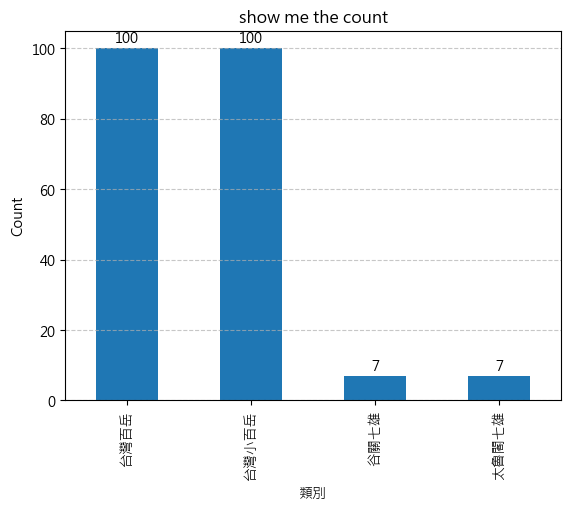

In [36]:
show_cnt2 = new_df['類別'].value_counts()
show_cnt2.plot(kind='bar')

# 添加標題和軸的標籤
plt.title('show me the count')
plt.xlabel('類別')
plt.ylabel('Count')

# 顯示數值標籤
for i, v in enumerate(show_cnt2):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [131]:
column_name = '相關步道'
unique_values = new_df[column_name].unique()
unique_values_cleaned = new_df[column_name].dropna().unique()
unique_values_sorted = sorted(unique_values_cleaned, key=len)
#unique_values
unique_values_sorted

['南二段',
 '南一段',
 '奇萊東稜',
 '獅山古道',
 '橫山步道',
 '草嶺古道',
 '五四縱走',
 '虎山步道',
 '三員縱走',
 '龍鳳連稜',
 '雪山西稜線',
 '暗影山步道',
 '後尖山步道',
 '崁頭山步道',
 '白雲山步道',
 '大崗山步道',
 '棚集山步道',
 '女仍山步道',
 '鵲子山步道',
 '初音山步道',
 '月眉山步道',
 '都蘭山步道',
 '紅頭山步道',
 '雲台山步道',
 '蛇頭山步道',
 '仙跡岩步道',
 '和美山步道',
 '大粗坑古道',
 '林北魯拉拉',
 '峰頭尖步道',
 '竹子山古道',
 '石筍尖步道',
 '大崎棟古道',
 '鬼澤山步道',
 '北坑山步道',
 '馬崙山步道',
 '阿冷山山徑',
 '明舉山步道',
 '五指山古道',
 '二延平步道',
 '美崙山步道',
 '望洋山步道',
 '旗尾山步道',
 '月光山步道',
 '五峰天際線',
 '藤枝山步道',
 '新阿溪縱走',
 '那羅山步道',
 '百川山山徑',
 '足母山步道',
 '三方向古道',
 '十二寮古道',
 '大嶺巷步道',
 '九芎根步道',
 '溪頭山步道',
 '鵝尾山步道',
 '打牛崎古道',
 '五腳松古道',
 '石城山步道',
 '東埔山步道',
 '合歡東峰步道',
 '合歡主峰步道',
 '干卓萬群峰線',
 '十八尖山步道',
 '南觀音山步道',
 '大橫屏山步道',
 '九份二山步道',
 '大湖尖山步道',
 '竹子尖山步道',
 '加奈美山步道',
 '巴塱衛山步道',
 '五步哭山步道',
 '雪山尾稜全段',
 '羊稠森林步道',
 '野馬瞰山步道',
 '東洗水山步道',
 '鹿場大山步道',
 '榛山登山步道',
 '馬武霸山步道',
 '桐林花廊步道',
 '上內平林步道',
 '頂石棹步道群',
 '新溪洲山步道',
 '卡拉寶山步道',
 '大山母山步道',
 '墾丁龜山步道',
 '銅山登山步道',
 '鞍輪名山山徑',
 '基隆一日雙塔',
 '鳶山登山步道',
 '合歡尖山步道',
 '雲嘉十三連峰',
 '合歡南峰步道',
 '合歡石門山步道',
 '塔關山登山步道',
 '桃園金面山步道',
 '溪頭鳳凰山步道',
 

In [116]:
unique_counts = new_df.nunique()
unique_counts

山岳ID      3076
山岳名稱      3045
人想去        126
人去過        439
次點閱       1932
類別           4
別名         779
國家           1
所在縣市       486
標高        1657
所屬園區        30
所屬山系        88
申請入山         2
申請入園         2
相關步道       439
基點         516
備註          19
簡介         673
標高(值)     1657
標高(單位)       1
dtype: int64

In [64]:
duplicate_counts = new_df[new_df.duplicated(subset=['所在縣市'], keep=False)]['所在縣市'].value_counts()
duplicate_counts

花蓮縣花蓮市,花蓮縣花蓮市秀林鄉    77
南投縣南投市,南投縣南投市仁愛鄉    72
高雄市桃源區              55
台東縣海端鄉              51
新竹縣尖石鄉              49
                    ..
台中市和平區,台中市大安區        2
花蓮縣秀林鄉,台中市和平區        2
新竹縣竹東鎮,新竹縣北埔鄉        2
桃園市復興區,宜蘭縣大同鄉        2
新北市雙溪區,              2
Name: 所在縣市, Length: 274, dtype: int64

In [54]:
# 不同地點可能有山岳同名
filtered_df = new_df[new_df['山岳名稱'] == '枕頭山']
filtered_df

,山岳ID,山岳名稱,人想去,人去過,次點閱,類別,別名,國家,所在縣市,標高,所屬園區,所屬山系,申請入山,申請入園,相關步道,基點,備註,簡介
254,259,枕頭山,17,100,6080,NaN,巴拉卡山/百拉卡山,台灣,新北市三芝區,909公尺,陽明山國家公園,大屯山系,否,否,,無基點,,位於陽明山國家公園內的菜公坑古道是早期三芝菜公坑聚落居民通往大屯山鞍部的聯絡便道，經二子坪、...
309,315,枕頭山,12,72,7847,NaN,NaN,台灣,桃園市復興區,631公尺,-,雪山山脈,否,否,枕頭山古砲台歷史古道,三等三角點4185號一等衛星控制點,,枕頭山位於桃園復興鄉三民村的山區，山頂可俯瞰大漢溪及扼制附近各台地上的原住民聚落，百年前為兵...
386,392,枕頭山,6,17,2278,NaN,NaN,台灣,"苗栗縣三義鄉,苗栗縣卓蘭鎮",401公尺,-,-,否,否,,土地調查局圖根點,,
692,704,枕頭山,4,46,1824,NaN,NaN,台灣,台南市白河區,648公尺,-,-,否,否,,土地調查局圖根點,,枕頭山，標高648公尺，土地調查局圖根點在營區的山頭上，不能進入；從高速公路或嘉義平原海線一...
